In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import time

# Data

 - Two simulation cases are considered in the paper
 -- Due to privacy issues, we do not provide the original data in real applications. 
 -- However, we provide the simulated data.
 -- The simulated data are generated by manipulating the original data in real applications.
 - This is the __FIRST__ case.

## load data

In [2]:
# path for loading the simulated data
path = r'\simulated_data'
# path for saving results
path_save = r'\results'
# data for illustration
df = pd.read_excel(path+'\wheel1_simulated.xlsx')
# data of wheel #1-4 for training
df_wheel1 = pd.read_excel(path+'\wheel1_simulated.xlsx')
df_wheel2 = pd.read_excel(path+'\wheel2_simulated.xlsx')
df_wheel3 = pd.read_excel(path+'\wheel3_simulated.xlsx')
df_wheel4 = pd.read_excel(path+'\wheel4_simulated.xlsx')
# data of wheel #5 for test
df_wheel5 = pd.read_excel(path+'\wheel5_simulated.xlsx')

## show original data

In [3]:
df1 = df

print('number of observations on one wheel: ',df_wheel1.db.size)

number of observations on one wheel:  10711


In [4]:
df_wheel1.head()

,Unnamed: 0,mileage,db
0,0,20,12.513511
1,1,40,11.747744
2,2,60,17.114142
3,3,80,26.361180
4,4,100,37.117974


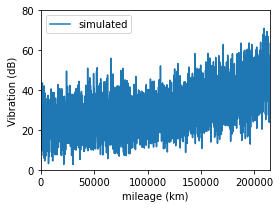

In [5]:
plt.rcParams["figure.figsize"] = (4,3)

plt.plot(df.mileage,df.db.rolling(4).mean(),label='simulated')

plt.xlabel('mileage (km)')
plt.ylabel('Vibration (dB)')
plt.ylim([0,80])
plt.xlim([0,215000])
plt.tight_layout()
plt.legend()

# Box-Cox transformation

- Technical details for Box-Cox transformation are provided in Section 3.1.1 in our paper

## illustration

- Given different values of $\alpha$, we calculate the 
-- $\lambda$ that maximizes the log-likelihood function; see the log-likelihood function is in Equation (4) in the paper
-- interval estimates for $\lambda$; see technical details in Equation (5) in the paper

In [6]:
for alpha in [0.0001,0.9]:
    signal_boxcox,max_lambda,ci_lambda = stats.boxcox(df1.db,alpha=alpha)
    print('================================================')
    print('alpha= ',alpha)
    print('lambda:',max_lambda)
    print('ci_lambda',ci_lambda)

alpha=  0.0001
lambda: 0.6906063430259698
ci_lambda (0.6476293455120566, 0.7343300820201404)
alpha=  0.9
lambda: 0.6906063430259698
ci_lambda (0.6892065862799533, 0.6920068429441286)


## application

### DEF: Box Cox transformation for our data

- find the ML estimate of $\lambda$ first, denoted as $\hat\lambda$

In [7]:
signal_boxcox,max_lambda,ci_lambda = stats.boxcox(df_wheel1.db.rolling(1).mean(),alpha=0.025)
print('=====================')
print('lambda ML estimate         :  ',max_lambda)
print('lambda confidence interval :  ',ci_lambda)

lambda ML estimate         :   0.6906063430259698
lambda confidence interval :   (0.6657561631849201, 0.7157043428165942)


- set different values of $\lambda$ around ML estimate $\hat{\lambda}$

In [8]:
def box_cox_on_data(df,lambdas):
    signal = df.db.rolling(4).mean()
    
    # first, calculate the best lambda
    signal_boxcox,max_lambda,ci_lambda = stats.boxcox(signal,alpha=0.025)
    print('================================================================================')
    print('lambda ML estimate         :',max_lambda)
    print('lambda confidence interval :',ci_lambda)

    # define the dataframe
    df_boxcox = pd.DataFrame({'mileage' : df.mileage})
    signals_names = []
    signals_var_names = []
    for lamb in lambdas:
        signal_boxcox = stats.boxcox(x = signal,lmbda = lamb)
        name = 'signal_boxcox_lamb'+str(lamb)
        signals_names.append(name)
        df_boxcox[name] = signal_boxcox
        name2 = 'signal_boxcox_var_lamb'+str(lamb)
        signals_var_names.append(name2)
        df_boxcox[name2] = df_boxcox[name].rolling(10).std()

    df_boxcox = df_boxcox.dropna() # drop the NaN
    df_boxcox = df_boxcox.reset_index()
    return df_boxcox,signals_names

### box_cox transformation on all wheels data

In [10]:
lambdas= [0.3,0.4,0.5,0.65,0.7,0.8,0.9]

df_wheel1_boxcox,signals_names = box_cox_on_data(df_wheel1,lambdas)
df_wheel2_boxcox,signals_names = box_cox_on_data(df_wheel2,lambdas)
df_wheel3_boxcox,signals_names = box_cox_on_data(df_wheel3,lambdas)
df_wheel4_boxcox,signals_names = box_cox_on_data(df_wheel4,lambdas)
df_wheel5_boxcox,signals_names = box_cox_on_data(df_wheel5,lambdas)

lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)


### show the transformed data

lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)


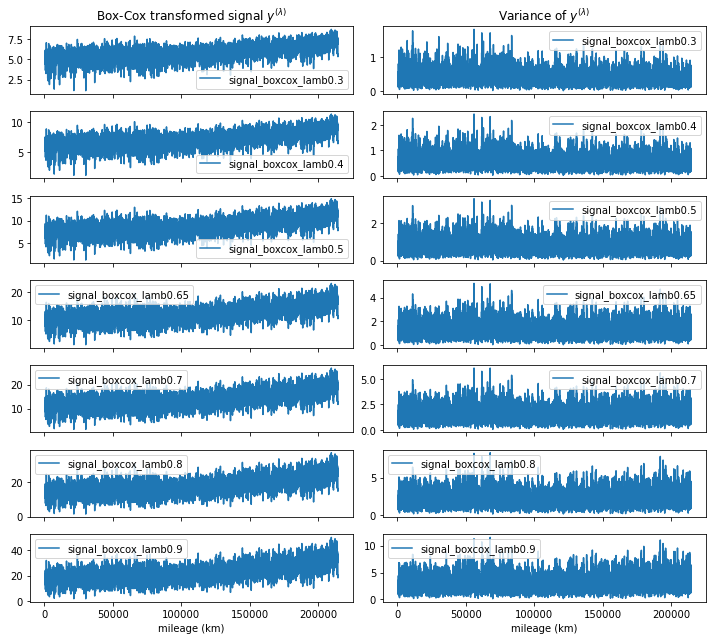

In [11]:
df_boxcox,signals_names = box_cox_on_data(df_wheel1,lambdas)

fig,axs = plt.subplots(7,2,sharex = True, figsize=(10,9))

i = 0
for key in signals_names:
    axs[i,0].plot(df_boxcox['mileage'],df_boxcox[key], label = key)
    axs[i,1].plot(df_boxcox['mileage'],df_boxcox[key].rolling(4).std(), label = key)
    # axs[i,1].hist(df_boxcox[key], bins = 25, density = True, edgecolor = 'black',alpha = 0.8, label = key)
    i = i+1
    
axs[6,0].set_xlabel('mileage (km)')
axs[6,1].set_xlabel('mileage (km)')
axs[0,0].set_title('Box-Cox transformed signal $y^{(\lambda)}$')
axs[0,1].set_title('Variance of $y^{(\lambda)}$')


for axs in fig.get_axes():
    axs.legend()
    axs.set_xticks(np.arange(0,230000,50000))

plt.tight_layout()

plt.savefig(path_save+'\wheel1.png',dpi = 500)
plt.savefig(path_save+'\wheel1.svg',dpi = 500)

- have a look at the transformed data

In [12]:
df_wheel1_boxcox.head()

,index,mileage,signal_boxcox_lamb0.3,signal_boxcox_var_lamb0.3,signal_boxcox_lamb0.4,signal_boxcox_var_lamb0.4,signal_boxcox_lamb0.5,signal_boxcox_var_lamb0.5,signal_boxcox_lamb0.65,signal_boxcox_var_lamb0.65,signal_boxcox_lamb0.7,signal_boxcox_var_lamb0.7,signal_boxcox_lamb0.8,signal_boxcox_var_lamb0.8,signal_boxcox_lamb0.9,signal_boxcox_var_lamb0.9
0,12,260,4.924946,0.665993,5.880844,0.908380,7.072243,1.239570,9.445949,1.977692,10.436232,2.311474,12.797710,3.158639,15.785124,4.318273
1,13,280,5.637992,0.650622,6.859310,0.887289,8.415013,1.210624,11.604868,1.931140,12.965501,2.256929,16.269339,3.083744,20.550519,4.215416
2,14,300,5.725798,0.673060,6.981647,0.917795,8.585459,1.252080,11.885177,1.996743,13.296369,2.333355,16.730325,3.187426,21.192796,4.355990
3,15,320,5.030871,0.656719,6.024479,0.896041,7.267014,1.223157,9.753501,1.952523,10.794370,2.282451,13.283350,3.120051,16.443660,4.266968
4,16,340,5.596231,0.607723,6.801266,0.827118,8.334336,1.126216,11.472668,1.790860,12.809644,2.090755,16.052710,2.850541,20.249423,3.888110


In [13]:
print('signals_names:\n',signals_names)

signals_names:
 ['signal_boxcox_lamb0.3', 'signal_boxcox_lamb0.4', 'signal_boxcox_lamb0.5', 'signal_boxcox_lamb0.65', 'signal_boxcox_lamb0.7', 'signal_boxcox_lamb0.8', 'signal_boxcox_lamb0.9']


# N-Beats for prediction

In [14]:
import torch
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, layers

from numpy.random import seed

seed(1)

In [15]:
# pip install nbeats-keras

In [16]:
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch

## train the model

### check if the dataframe have the same length

In [17]:
print('======== some information about the original data ======')
dfs = [df_wheel1_boxcox,
       df_wheel2_boxcox,
       df_wheel3_boxcox,
       df_wheel4_boxcox]
for df in dfs:
    print('number of measurements on a wheel:',df.mileage.size)

======== some information about the original data ======
number of measurements on a wheel: 10699
number of measurements on a wheel: 10699
number of measurements on a wheel: 10699
number of measurements on a wheel: 10699


### TrainTestData

In [18]:
def TrainTestData(forecast_length,backcast_length,dfs,lamb,n,train_percent):
    forecast_length
    backcast_length

    # source domain data : lambda = 0.65 in simulation case #1
    lamb

    # generate the data into standard data shape
    x = []
    y = []
    t_x = []
    t_y = []
    for df in dfs:
        t = np.array(df.mileage)
        HI = np.array(df["signal_boxcox_lamb"+str(lamb)])
        for j in range(backcast_length,len(HI)-forecast_length,1):
            t_x.append(t[j-backcast_length:j].reshape(backcast_length,1))
            t_y.append(t[j:j+forecast_length].reshape(forecast_length,1))
            x.append(HI[j-backcast_length:j].reshape(backcast_length,1))
            y.append(HI[j:j+forecast_length].reshape(forecast_length,1))
        
    x = np.asarray(x) 
    y = np.asarray(y)
    t_x = np.asarray(t_x)
    t_y = np.asarray(t_y)
    
    # split data into training and testing datasets.
    # C is the number of total observations for four wheel
    # c is the numeber of observations of one wheel
    # w is the percent we want to use as training data
    print('total number of wheels in this dataset : ',n)
    C = x.shape[0]
    print('C - number of total observations for wheel : ',C)
    c = int(C/n)
    print('c - numeber of observations of one wheel: ',c)
    w = int(c*train_percent)
    print('w - the percent we want to use as training data: ',w)            
          
    # When seperating the data in dfs into training data and test data
    # we should consider two cases
    # （1）The first case is the number of wheels in our dfs dataset is larger than 1
    # this is usually the case when we want to train our model on the source domain
    # （2）The second case is the number of the wheels in our dfs dataset is equal to 1
    # this is usually the case when we want to fine-tune our model on the target domain
    
    # the training data from one wheel
    x_train = x[0:w]
    y_train = y[0:w]
    # the test data from one wheel
    x_test = x[w:c]
    y_test = y[w:c]
    # the mileages from training data
    t_x_train = t_x[0:w]
    t_y_train = t_y[0:w]
    # the mileages from the test data
    t_x_test = t_x[w:c]
    t_y_test = t_y[w:c]
    if n > 1:
        for i in range(1,n,1):
            # concatenate the training data from n wheels
            x_train = np.concatenate((x_train,x[i*c:i*c+w]))
            y_train = np.concatenate((y_train,y[i*c:i*c+w]))
            # concatenate the test data from n wheels
            x_test = np.concatenate((x_test,x[i*c+w:(i+1)*c]))
            y_test = np.concatenate((y_test,y[i*c+w:(i+1)*c]))
            # concatenate the mileages from training data of the n wheels
            t_x_train = np.concatenate((t_x_train,t_x[i*c:i*c+w]))
            t_y_train = np.concatenate((t_y_train,t_y[i*c:i*c+w]))
            # concatenate the mieages from the test data of the n wheels
            t_x_test = np.concatenate((t_x_test,t_x[i*c+w:(i+1)*c]))
            t_y_teat = np.concatenate((t_y_test,t_y[i*c+w:(i+1)*c]))

    test_size = len(x_test)
    
    # print('test_size = ',test_size)
    
    return x, y, t_x, t_y, x_train, y_train, x_test, y_test, t_x_train, t_y_train, t_x_test, t_y_test, t, HI

In [19]:
dfs[0].shape

(10699, 16)

In [20]:
dfs[0].size

171184

### train the model on training dataset

In [77]:
forecast_length = 20
backcast_length = 40
# we select the feature when lambda = 0.65 as the source domain feature
lamb = 0.65
n = 4
train_percent = 0.6
results = TrainTestData(forecast_length,
                        backcast_length,
                        dfs,
                        lamb,
                        n,
                        train_percent)

x = results[0] 
y = results[1]
t_x = results[2] 
t_y = results[3]
x_train = results[4] 
y_train = results[5] 
x_test = results[6]
y_test = results[7] 
t_x_train = results[8]
t_y_train = results[9] 
t_x_test = results[10] 
t_y_test = results[11] 
t = results[12] 
HI = results[13]

total number of wheels in this dataset :  4
C - number of total observations for wheel :  42556
c - numeber of observations of one wheel:  10639
w - the percent we want to use as training data:  6383


In [78]:
# NOTE: If you choose the Keras backend with input_dim>1, you have 
# to set the value here too (in the constructor).
output_dim = 1

test_size = len(x_test)

backend = NBeatsKeras(          
    backcast_length=backcast_length, 
    forecast_length=forecast_length,            
    stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.GENERIC_BLOCK),            
    nb_blocks_per_stack=6, 
    thetas_dim=(4, 4), 
    share_weights_in_stack=True,
    hidden_layer_units=3
)

# Definition of the objective function and the optimizer.
backend.compile(loss='mae', 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Train the model.
print('Training...')
backend.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=16)

# Save the model for later use
backend.save('n_beats_model_trained_on_lam'+str(lamb)+'.h5')
backend.save('n_beats_model.h5')

# Predict on the testing set (forecast).
predictions_forecast = backend.predict(x_test)

# Predict on the testing set (backcast).
predictions_backcast = backend.predict(x_test, return_backcast=True)

# Load the model.
model_2 = NBeatsKeras.load('n_beats_model_trained_on_lam'+str(lamb)+'.h5')


Training...
Epoch 1/20
1596/1596 [==============================] - 5s 2ms/step - loss: 2.5170 - val_loss: 1.6977
Epoch 2/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.8048 - val_loss: 1.7642
Epoch 3/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.7940 - val_loss: 2.0679
Epoch 4/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.7872 - val_loss: 2.1917
Epoch 5/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.7838 - val_loss: 1.8813
Epoch 6/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.7819 - val_loss: 2.0601
Epoch 7/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.7794 - val_loss: 2.2366
Epoch 8/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.7772 - val_loss: 2.2105
Epoch 9/20
1596/1596 [==============================] - 3s 2ms/step - loss: 1.7736 - val_loss: 2.2303
Epoch 10/20
1596/1596 [==============================] - 3s 2ms/step -

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [79]:
# have a look at the structure of our model
backend.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 40, 1)]      0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 40)           0           ['input_variable[0][0]']         
                                                                                                  
 0/0/generic/d1 (Dense)         (None, 3)            123         ['lambda_1[0][0]',               
                                                                  'subtract_12[0][0]',            
                                                                  'subtract_13[0][0]',            
                                                                  'subtract_14[0][0]',     

### perfomance of the trained model on test data

In [80]:
test_size = np.int(t.size/n)

C:\Users\yanbi\AppData\Local\Temp/ipykernel_11584/3350379849.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_size = np.int(t.size/n)


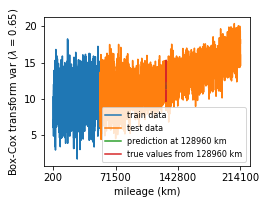

In [81]:
# this is the index, where the data before it is used for training, and the data after it is used for testing

plt.figure(figsize=(3.8,2.8))

plt.plot(t[0:test_size],HI[0:test_size],label='train data')
plt.plot(t[test_size:],HI[test_size:],label='test data')

for i in [12]:
    plt.plot(t_y_test[i],predictions_forecast[i],label='prediction at '+str(int(t_y_test[i][0][0]))+' km')
    plt.plot(t_y_test[i],y_test[i],label='true values from '+str(int(t_y_test[i][0][0]))+' km')

plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

plt.xticks(np.arange(int(np.min(df_boxcox.mileage)/100)*100, np.max(df_boxcox.mileage), int((np.max(df_boxcox.mileage)-np.min(df_boxcox.mileage))/300)*100))

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(path_save+'\BC_'+str(lamb)+'_pred_at'+str(int(t_y_test[i][0]))+'.png',dpi=500)
plt.savefig(path_save+'\BC_'+str(lamb)+'_pred_at'+str(int(t_y_test[i][0]))+'.svg',dpi=500)

number of the observations for test data 17024


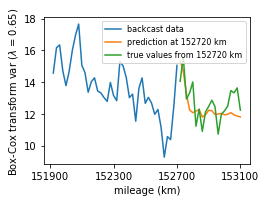

In [82]:
print('number of the observations for test data',len(x_test))

plt.figure(figsize=(3.8,2.8))

for i in [1200]:
    plt.plot(t_x_test[i],x_test[i],label='backcast data')
    plt.plot(t_y_test[i],predictions_forecast[i],label='prediction at '+str(int(t_y_test[i][0][0]))+' km')
    plt.plot(t_y_test[i],y_test[i],label='true values from '+str(int(t_y_test[i][0][0]))+' km')

    
plt.xticks(np.arange(int(np.min(t_x_test[i])/100)*100, np.max(t_y_test[i]+100), int((np.max(t_y_test[i])-np.min(t_x_test[i]))/250)*100))

    
plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'_zoomin.png',dpi=500)
plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test[i][0]))+'_zoomin.svg',dpi=500)

## transfer learning with fine tuning

### define the target domain data

In [83]:
forecast_length = 20
backcast_length = 40

 
# The target domian data whose BoxCox transfomation parameter is lambda
# In this case, we want to train a model on feature with lambda = 0.65, 
# and transfer the trained model to feature with lambda = 0.4

lamb = 0.4
n  = 1
train_percent = 0.3
results = TrainTestData(forecast_length,
                        backcast_length,
                        [df_wheel5_boxcox],
                        lamb,
                        n,
                        train_percent)

x_transfer = results[0]
y_transfer = results[1]
t_x_transfer = results[2]
t_y_transfer = results[3]
x_train_transfer = results[4] 
y_train_transfer = results[5]
x_test_transfer = results[6]
y_test_transfer = results[7]
t_x_train_transfer = results[8] 
t_y_train_transfer = results[9] 
t_x_test_transfer = results[10] 
t_y_test_transfer = results[11]

total number of wheels in this dataset :  1
C - number of total observations for wheel :  10639
c - numeber of observations of one wheel:  10639
w - the percent we want to use as training data:  3191


In [84]:
df_wheel5_boxcox

,index,mileage,signal_boxcox_lamb0.3,signal_boxcox_var_lamb0.3,signal_boxcox_lamb0.4,signal_boxcox_var_lamb0.4,signal_boxcox_lamb0.5,signal_boxcox_var_lamb0.5,signal_boxcox_lamb0.65,signal_boxcox_var_lamb0.65,signal_boxcox_lamb0.7,signal_boxcox_var_lamb0.7,signal_boxcox_lamb0.8,signal_boxcox_var_lamb0.8,signal_boxcox_lamb0.9,signal_boxcox_var_lamb0.9
0,12,260,5.419699,0.320216,6.556903,0.434692,7.996078,0.590176,10.921772,0.933888,12.161491,1.088336,15.155499,1.478236,19.007447,2.008092
1,13,280,5.134212,0.260939,6.165196,0.355691,7.458624,0.484873,10.057960,0.771802,11.149646,0.901177,13.767124,1.228671,17.102406,1.675267
2,14,300,6.093262,0.401685,7.497886,0.553656,9.310718,0.763310,13.092905,1.236218,14.727889,1.451936,18.741544,2.003242,24.018504,2.764571
3,15,320,5.610094,0.421542,6.820524,0.580808,8.361089,0.800429,11.516472,1.295515,12.861274,1.521244,16.124434,2.097907,20.349062,2.893833
4,16,340,5.453829,0.402584,6.604020,0.554928,8.061124,0.765095,11.027279,1.239131,12.285457,1.455350,15.326636,2.007902,19.243705,2.770878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10694,10706,214140,7.235064,0.157565,9.144313,0.231538,11.685079,0.340246,17.205836,0.606129,19.667725,0.734784,25.868005,1.079829,34.300744,1.586933
10695,10707,214160,7.304676,0.158185,9.246690,0.232421,11.835644,0.341502,17.474373,0.608256,19.993384,0.737318,26.346947,1.083421,35.005118,1.592018
10696,10708,214180,7.399193,0.156698,9.386053,0.230217,12.041130,0.338236,17.842277,0.602361,20.440122,0.730142,27.005651,1.072787,35.976358,1.576262
10697,10709,214200,7.419951,0.121994,9.416714,0.179522,12.086421,0.264179,17.923585,0.471605,20.538941,0.572103,27.151617,0.841918,36.191967,1.238995


### fine tuning the trained model

In [85]:
# Load the model.
model_trained = NBeatsKeras.load('n_beats_model.h5')

In [86]:
# See what the model look like
model_trained.summary()
# model_trained.layers[-3]

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 40, 1)]      0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 40)           0           ['input_variable[0][0]']         
                                                                                                  
 0/0/generic/d1 (Dense)         (None, 3)            123         ['lambda_1[0][0]',               
                                                                  'subtract_12[0][0]',            
                                                                  'subtract_13[0][0]',            
                                                                  'subtract_14[0][0]',     

In [87]:
# freeze all layers
model_trained.trainable = False
# set some layers free
model_trained.layers[-6].trainable = True
model_trained.layers[-3].trainable = True
print('Is the model trainable ?     Answer: ',model_trained.trainable)
print('Is any layer trainbale ?     Answer: ',model_trained.layers[-6].trainable)

Is the model trainable ?     Answer:  False
Is any layer trainbale ?     Answer:  True


In [88]:
# Train the model.
print('Re-Training...')
    
history = model_trained.fit(x_train_transfer, 
                  y_train_transfer, 
                  validation_data=(x_test_transfer, y_test_transfer), 
                  epochs=10, 
                  batch_size=16)

# Save the model for later.
model_trained.save('n_beats_model_transfer.h5')

# Predict on the testing set (forecast).
predictions_forecast_transfer = model_trained.predict(x_test_transfer)

Re-Training...
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.9485 - val_loss: 1.0194
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8629 - val_loss: 0.9267
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8605 - val_loss: 0.9846
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8604 - val_loss: 0.9492
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8591 - val_loss: 0.9806
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8588 - val_loss: 0.9675
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8579 - val_loss: 0.9604
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8580 - val_loss: 1.0089
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8578 - val_loss: 1.0017
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.8575 - v

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### transfer results plot

7448


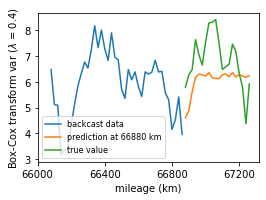

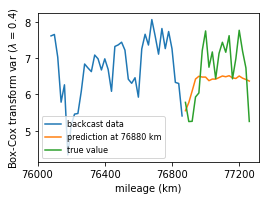

In [89]:
print(len(x_test_transfer))

for i in range(100,1000,500):
    plt.figure(figsize=(3.8,2.8))
    plt.plot(t_x_test_transfer[i],x_test_transfer[i],label='backcast data')
    plt.plot(t_y_test_transfer[i],predictions_forecast_transfer[i],label='prediction at '+str(int(t_y_test_transfer[i][0]))+ ' km')
    plt.plot(t_y_test_transfer[i],y_test_transfer[i],label='true value')

    plt.xticks(np.arange(int(np.min(t_x_test_transfer[i])/100)*100, np.max(t_y_test_transfer[i]+100), int((np.max(t_y_test_transfer[i])-np.min(t_x_test_transfer[i]))/250)*100))

    plt.xlabel('mileage (km)')
    plt.ylabel('Box-Cox transform var ($\lambda$ = '+str(lamb)+')')

    plt.tight_layout()

    plt.legend(fontsize=8)
    plt.savefig(path_save+'\BC_'+str(lamb)+'_pred_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.png',dpi=500)
    plt.savefig(path_save+'\BC_'+str(lamb)+'_pred_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.svg',dpi=500)

## predict feature on wheel5

### load the trained model on dataset {wheel1-4}
-  lambda=0.65

In [90]:
lamb = 0.65
model_trained = NBeatsKeras.load('n_beats_model_trained_on_lam'+str(lamb)+'.h5')

### define the data of wheel5

In [91]:
forecast_length = 20
backcast_length = 40
# we select the feature when lambda = 0.65 as the source domain feature
lamb = 0.65
n = 1
train_percent = 0.3
results = TrainTestData(forecast_length,
                        backcast_length,
                        [df_wheel5_boxcox],
                        lamb,
                        n,
                        train_percent)

x_transfer = results[0] 
y_transfer = results[1]
t_x_transfer = results[2] 
t_y_transfer = results[3]
x_train_transfer = results[4] 
y_train_transfer = results[5] 
x_test_transfer = results[6]
y_test_transfer = results[7] 
t_x_train_transfer = results[8]
t_y_train_transfer = results[9] 
t_x_test_transfer = results[10] 
t_y_test_transfer = results[11] 
t_transfer = results[12] 
HI_transfer = results[13]

total number of wheels in this dataset :  1
C - number of total observations for wheel :  10639
c - numeber of observations of one wheel:  10639
w - the percent we want to use as training data:  3191


### fine tuning the trained model 
- with some data on wheel5

In [92]:
model_trained.trainable = False
model_trained.layers[-6].trainable = True
model_trained.layers[-3].trainable = True
print(model_trained.trainable)
print(model_trained.layers[-6].trainable)

False
True


In [93]:
# Train the model.
print('Re-Training...')
    
history = model_trained.fit(x_train_transfer, 
                  y_train_transfer, 
                  validation_data=(x_test_transfer, y_test_transfer), 
                  epochs=10, 
                  batch_size=16)

# Save the model for later.
model_trained.save('n_beats_model_transfer.h5')

# Predict on the testing set (forecast).
predictions_forecast_transfer = model_trained.predict(x_test_transfer)

Re-Training...
Epoch 1/10
200/200 [==============================] - 2s 5ms/step - loss: 1.8767 - val_loss: 2.3492
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8750 - val_loss: 2.3053
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8730 - val_loss: 2.2197
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8719 - val_loss: 2.2418
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8699 - val_loss: 2.3163
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8690 - val_loss: 2.3318
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8702 - val_loss: 2.2833
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8696 - val_loss: 2.3761
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8676 - val_loss: 2.3367
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 1.8677 - v

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### prediction result plot

C:\Users\yanbi\AppData\Local\Temp/ipykernel_11584/3162945840.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx5 = forecast_length*np.int(t_transfer.size*train_percent/forecast_length)


t_transfer.size: 10699
idx5:  3200
prediction mileage: 64260


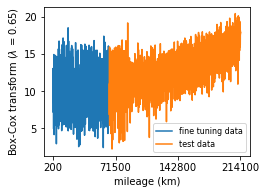

In [94]:
plt.figure(figsize=(3.8,2.8))

idx5 = forecast_length*np.int(t_transfer.size*train_percent/forecast_length)

print('t_transfer.size:',t_transfer.size)
print('idx5: ',idx5)
print('prediction mileage:',t_transfer[idx5])

plt.plot(t_transfer[0:idx5],HI_transfer[0:idx5],label='fine tuning data')
plt.plot(t_transfer[idx5:],HI_transfer[idx5:],label='test data')
 
plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform ($\lambda$ = '+str(lamb)+')')

plt.xticks(np.arange(int(np.min(df_boxcox.mileage)/100)*100, np.max(df_boxcox.mileage), int((np.max(df_boxcox.mileage)-np.min(df_boxcox.mileage))/300)*100))

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_transfer[idx5]))+'.png',dpi=500)
plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_transfer[idx5]))+'.svg',dpi=500)

- np.concatenate the test data

In [95]:
x_test_transfer = x_test_transfer.reshape((-1,1))
t_x_test_transfer = t_x_test_transfer.reshape((-1,1))
t_y_test_transfer = t_y_test_transfer.reshape((-1,1))
predictions_forecast_transfer = predictions_forecast_transfer.reshape((-1,1))
y_test_transfer = y_test_transfer.reshape((-1,1))

print(t_x_test_transfer.shape)
print(x_test_transfer.shape)

(297920, 1)
(297920, 1)


297920


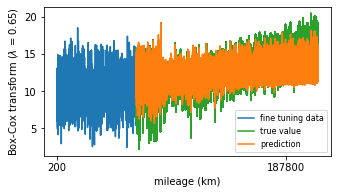

In [96]:
print(len(x_test_transfer))

plt.figure(figsize=(4.8,2.8))

plt.plot(t_transfer,HI_transfer,label='fine tuning data')
plt.plot(t_y_test_transfer,y_test_transfer,label='true value',color='tab:green')
plt.plot(t_y_test_transfer,predictions_forecast_transfer,label='prediction',color='tab:orange')

plt.xticks(np.arange(int(np.min(t_transfer)/100)*100, np.max(t_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/80)*100))

plt.xlabel('mileage (km)')
plt.ylabel('Box-Cox transform ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.png',dpi=500)
plt.savefig(path_save+'\BC_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_zoomin.svg',dpi=500)

# reconstruct the original signals

## reconstruct original signal based on feature with lambda

In [97]:
from scipy.special import inv_boxcox

In [352]:
idx0 = 0
idx1 = df_wheel1_boxcox.size
idx2 = idx1+forecast_length

results = {}

# source domain data : lambda = 0.81

# define the target domain data
for lamb in lambdas:
    # generate the data into standard data shape
    x_transfer = []
    y_transfer = []
    t_x_transfer = []
    t_y_transfer = []
    for df in [df_wheel5_boxcox]:
        t_transfer = np.array(df.mileage[idx0:idx1])
        HI_transfer = np.array(df["signal_boxcox_lamb"+str(lamb)][idx0:idx1])
        for j in range(backcast_length,len(HI_transfer)-forecast_length,forecast_length):
            t_x_transfer.append(t_transfer[j-backcast_length:j].reshape(backcast_length,1))
            t_y_transfer.append(t_transfer[j:j+forecast_length].reshape(forecast_length,1))
            x_transfer.append(HI_transfer[j-backcast_length:j].reshape(backcast_length,1))
            y_transfer.append(HI_transfer[j:j+forecast_length].reshape(forecast_length,1))

    x_transfer = np.asarray(x_transfer) 
    y_transfer = np.asarray(y_transfer)
    t_x_transfer = np.asarray(t_x_transfer)
    t_y_transfer = np.asarray(t_y_transfer)

    C = np.int(x_transfer.shape[0]*train_percent)

    x_train_transfer = x_transfer[:C]
    y_train_transfer = y_transfer[:C]
    x_test_transfer = x_transfer[C:]
    y_test_transfer = y_transfer[C:]
    t_x_train_transfer = t_x_transfer[:C]
    t_y_train_transfer = t_y_transfer[:C]
    t_x_test_transfer = t_x_transfer[C:]
    t_y_test_transfer = t_y_transfer[C:]

    model_trained.trainable = False
    model_trained.layers[-6].trainable = True
    model_trained.layers[-3].trainable = True
    print(model_trained.trainable)
    print(model_trained.layers[-6].trainable)

    # Train the model.
    print('Re-Training...')
    
    history = model_trained.fit(x_train_transfer, 
                  y_train_transfer, 
                  validation_data=(x_test_transfer, y_test_transfer), 
                  epochs=5, 
                  batch_size=16)

    # Save the model for later.
    model_trained.save('n_beats_model_transfer.h5')

    # Predict on the testing set (forecast).
    predictions_forecast_transfer = model_trained.predict(x_test_transfer)

    x_test_transfer = x_test_transfer.reshape((-1,1))
    t_x_test_transfer = t_x_test_transfer.reshape((-1,1))
    t_y_test_transfer = t_y_test_transfer.reshape((-1,1))
    predictions_forecast_transfer = predictions_forecast_transfer.reshape((-1,1))
    y_test_transfer = y_test_transfer.reshape((-1,1))

    y_test_transfer_inv = inv_boxcox(y_test_transfer, lamb)
    predictions_forecast_transfer_inv = inv_boxcox(predictions_forecast_transfer, lamb)
    HI_transfer_inv = inv_boxcox(HI_transfer, lamb)

    # save the inversed data
    results['predictions_forecast_transfer_inv'+str(lamb)] = predictions_forecast_transfer_inv.reshape((-1))

print(results)

False
True
Re-Training...
Epoch 1/5
10/10 [==============================] - 0s 6ms/step - loss: 2.6817 - val_loss: 1.9649
Epoch 2/5
10/10 [==============================] - 0s 5ms/step - loss: 1.7184 - val_loss: 0.9528
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 0.9767 - val_loss: 0.5186
Epoch 4/5
 1/10 [==>...........................] - ETA: 0s - loss: 0.7879

C:\Users\yanbi\AppData\Local\Temp/ipykernel_11584/307941013.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  C = np.int(x_transfer.shape[0]*train_percent)


10/10 [==============================] - 0s 5ms/step - loss: 0.6477 - val_loss: 0.6958
Epoch 5/5
10/10 [==============================] - 0s 5ms/step - loss: 0.6258 - val_loss: 0.7915
False
True
Re-Training...
Epoch 1/5
10/10 [==============================] - 0s 6ms/step - loss: 1.0857 - val_loss: 1.2793
Epoch 2/5
 1/10 [==>...........................] - ETA: 0s - loss: 1.0229

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


10/10 [==============================] - 0s 5ms/step - loss: 0.9332 - val_loss: 0.9579
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 0.8438 - val_loss: 0.7838
Epoch 4/5
10/10 [==============================] - 0s 5ms/step - loss: 0.8365 - val_loss: 0.7553
Epoch 5/5
10/10 [==============================] - 0s 4ms/step - loss: 0.8353 - val_loss: 0.7994
False
True
Re-Training...
Epoch 1/5
10/10 [==============================] - 0s 6ms/step - loss: 1.2581 - val_loss: 1.2792
Epoch 2/5
10/10 [==============================] - 0s 5ms/step - loss: 1.1829 - val_loss: 1.0852
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 1.1532 - val_loss: 1.0725
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 1.1511 - val_loss: 1.1129
Epoch 5/5
10/10 [==============================] - 0s 5ms/step - loss: 1.1454 - val_loss: 1.1884
False
True
Re-Training...
Epoch 1/5
10/10 [==============================] - 0s 6ms/step - loss: 2.0790 - val_l

14920


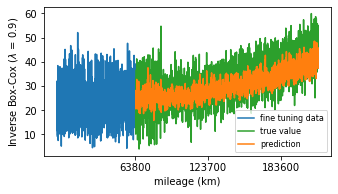

In [353]:
print(len(x_test_transfer))

plt.figure(figsize=(4.8,2.8))

plt.plot(t_transfer[0:idx5],HI_transfer_inv[0:idx5],label='fine tuning data')
plt.plot(t_y_test_transfer,y_test_transfer_inv,label='true value',color='tab:green')
plt.plot(t_y_test_transfer,predictions_forecast_transfer_inv,label='prediction',color='tab:orange')

plt.xticks(np.arange(int(np.min(t_x_test_transfer)/100)*100, np.max(t_y_test_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/250)*100))

plt.xlabel('mileage (km)')
plt.ylabel('Inverse Box-Cox ($\lambda$ = '+str(lamb)+')')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(path_save+'BC_inv_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.png',dpi=500)
plt.savefig(path_save+'BC_inv_'+str(lamb)+'_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.svg',dpi=500)

## signal fusion

### recovered signal

- calculate the mean value of all recovered signals

In [354]:
results_mean = pd.DataFrame.from_dict(results).mean(1)

print('results_mean:\n',results_mean)

results_mean:
 0       20.943069
1       20.865641
2       21.385107
3       22.454142
4       21.767469
          ...    
7455    35.188942
7456    34.711739
7457    35.612408
7458    33.005016
7459    33.316959
Length: 7460, dtype: float32


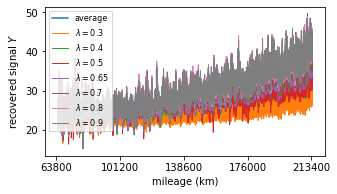

In [355]:
plt.figure(figsize=(4.8,2.8))

lambdas_inv = [0.3,0.4,0.5,0.65,0.7,0.8,0.9]

plt.plot(t_y_test_transfer,results_mean,label='average')

for lamb in lambdas_inv:
    plt.plot(t_y_test_transfer,
             results['predictions_forecast_transfer_inv'+str(lamb)],
             label='$\lambda=$'+str(lamb),linewidth=1)
    
plt.xticks(np.arange(int(np.min(t_x_test_transfer)/100)*100, np.max(t_y_test_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/400)*100))

plt.xlabel('mileage (km)')
plt.ylabel('recovered signal $Y$')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(path_save+'BC_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.png',dpi=500)
plt.savefig(path_save+'BC_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'.svg',dpi=500)

### distribution of recovered  signals

In [356]:
import seaborn as sns

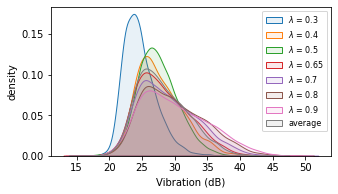

In [357]:
plt.figure(figsize=(4.8,2.8))

lambdas_inv = [0.3,0.4,0.5,0.65,0.7,0.8,0.9]

for lamb in lambdas_inv:
    sns.kdeplot(data = results['predictions_forecast_transfer_inv'+str(lamb)],
                fill = True,
                alpha = 0.1,
                palette="Paired",
                linewidth = 1,
                label = '$\lambda$ = '+str(lamb))

sns.kdeplot(data = results_mean,
                fill = True,
                alpha = 0.1,
                palette="Paired",
                linewidth = 1,
                label = 'average')
    
#plt.xticks(np.arange(int(np.min(t_x_test_transfer)/100)*100, np.max(t_y_test_transfer+100), int((np.max(t_y_test_transfer)-np.min(t_x_test_transfer))/400)*100))

plt.xlabel('Vibration (dB)')
plt.ylabel('density')

plt.tight_layout()

plt.legend(fontsize=8)
plt.savefig(path_save+'BC_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_dist.png',dpi=500)
plt.savefig(path_save+'BC_inv_all_lambdas_prediction_at'+str(int(t_y_test_transfer[i][0]))+'_dist.svg',dpi=500)

# fault time prediction

## fault alarm on predictions

### Function: alarm

In [358]:
def alarm(signal_lamb,threshold):
    diff = signal_lamb-threshold
    alarm_num = []
    for j in range(0,len(diff),1):
        diff_uptoj = diff[0:j]
        cum_num = diff_uptoj[diff_uptoj>0]
        alarm_num.append(len(cum_num))
        
    print('==================================================================')
    print('length of alarm_num:',len(alarm_num))

    return alarm_num

### Function: find the first index

In [359]:
def first_index(df,value):
    indices = df.index
    index_bool = df["mileage"] > value
    index = indices[index_bool]
    index = index[0]
    
    return index

### calculate the true cumulative number: true results

In [471]:
threshold = 42
# find the "index" where we conduct prediction
# we also need to use data after the "index" to compute the cumulative number
index = first_index(df_wheel5,t_y_test_transfer[0][0])
df_wheel5_boxcox_lamb1,signals_names = box_cox_on_data(df_wheel5[index:],[1])
signal_lamb_true = df_wheel5_boxcox_lamb1['signal_boxcox_lamb1']
signal_lamb_true = signal_lamb_true.rolling(30).mean()
alarm_num_true = alarm(signal_lamb_true,threshold)

lambda ML estimate         : 8.472135811722177
lambda confidence interval : (1.9263406583655017e-12, 1.0200137480435589e-12)
length of alarm_num: 7466


- plot the data we use to compute the true cumultive alarm number 

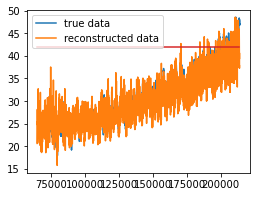

In [472]:
plt.plot(df_wheel5_boxcox_lamb1.mileage,signal_lamb_true,label='true data')
plt.plot(t_y_test_transfer,signal_lamb,label='reconstructed data')
plt.plot([min(t_y_test_transfer),max(t_y_test_transfer)],[threshold,threshold],'tab:red')
plt.legend()

### calculate the cumulative based on mean: prediction results

In [473]:
signal_lamb = results_mean
alarm_num_mean = alarm(signal_lamb,threshold)

length of alarm_num: 7460


### plot result

length of alarm_num: 7460
length of alarm_num: 7460
length of alarm_num: 7460
length of alarm_num: 7460
length of alarm_num: 7460
length of alarm_num: 7460
length of alarm_num: 7460


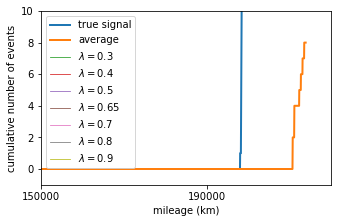

In [480]:
plt.figure(figsize=(4.8,3.2))

# plt.plot(df_wheel5_boxcox.mileage,alarm_num_true,label='true signal')

plt.plot(df_wheel5_boxcox_lamb1.mileage,alarm_num_true,label='true signal',linewidth=2)
plt.plot(t_y_test_transfer,alarm_num_mean,label='average',linewidth=2)
for lamb in lambdas:
    signal_lamb = results['predictions_forecast_transfer_inv'+str(lamb)]
    alarm_num = alarm(signal_lamb,lamb)
    plt.plot(t_y_test_transfer,alarm_num,label='$\lambda = $'+str(lamb),linewidth=0.8)
 
plt.xticks(np.arange(70000,230000,40000))

plt.xlim([150000,220000])
plt.ylim([-1,10])

plt.xlabel('mileage (km)')
plt.ylabel('cumulative number of events')

plt.legend()
plt.tight_layout()

plt.savefig(path_save+'alarm_num.png',dpi=500)
plt.savefig(path_save+'alarm_num.svg',dpi=500)

- compute the MAE of predictions

In [490]:
print('===================================================')
print('make prediction at: ', t_y_test_transfer[0][0])
print('===================================================')
failure_count = 6
# failure time of the true data
alarm_num_true = pd.Series(alarm_num_true)
failure_index_true = alarm_num_true[alarm_num_true>failure_count].index[0]
failure_time_true = df_wheel5_boxcox_lamb1.mileage[failure_index_true]
rul_true = failure_time_true-df_wheel5_boxcox_lamb1.mileage[0]
print('failure_time_true: ',failure_time_true)
print('rul_true: ',rul_true)
# failure time by predictions
alarm_num_mean = pd.Series(alarm_num_mean)
failure_index_mean = alarm_num_mean[alarm_num_mean>failure_count].index[0]
failure_time_mean = t_y_test_transfer[failure_index_mean][0]
rul_mean = failure_time_mean-t_y_test_transfer[0][0]
print('failure_time_mean: ',failure_time_mean)
print('rul_mean: ',rul_mean)

MAE = np.abs(rul_mean-rul_true)/rul_true
print('===================================================')
print('The results in Table.7 in the paper')
print('MAE: ',MAE)
print('===================================================')

make prediction at:  64660
failure_time_true:  198340
rul_true:  133420
failure_time_mean:  213080
rul_mean:  148420
The results in Table.7 in the paper
MAE:  0.11242692250037475


### prediction on failure time

length of alarm_num: 7460
lamb: 0.3    failure_time: 64700
length of alarm_num: 7460
lamb: 0.4    failure_time: 64700
length of alarm_num: 7460
lamb: 0.5    failure_time: 64700
length of alarm_num: 7460
lamb: 0.65    failure_time: 64700
length of alarm_num: 7460
lamb: 0.7    failure_time: 64700
length of alarm_num: 7460
lamb: 0.8    failure_time: 64700
length of alarm_num: 7460
lamb: 0.9    failure_time: 64700
length of alarm_num: 7460
lamb: 0.3    failure_time: 64720
length of alarm_num: 7460
lamb: 0.4    failure_time: 64720
length of alarm_num: 7460
lamb: 0.5    failure_time: 64720
length of alarm_num: 7460
lamb: 0.65    failure_time: 64720
length of alarm_num: 7460
lamb: 0.7    failure_time: 64720
length of alarm_num: 7460
lamb: 0.8    failure_time: 64720
length of alarm_num: 7460
lamb: 0.9    failure_time: 64720
length of alarm_num: 7460
lamb: 0.3    failure_time: 64740
length of alarm_num: 7460
lamb: 0.4    failure_time: 64740
length of alarm_num: 7460
lamb: 0.5    failure_time: 6

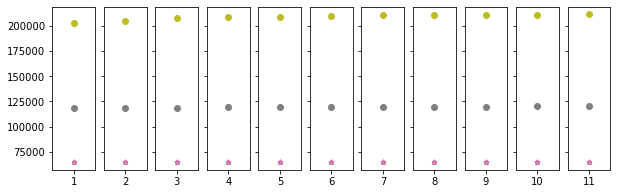

In [421]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(10, 3), sharey=True)

failure_counts = [1,2,3,4,5,6,7,8,9,10,11]
i = 0
# lambdas = [0.3,0.5,0.65,0.7,0.8,0.9]

for failure_count in failure_counts:  
    alarm_num_true = pd.Series(alarm_num_true)
    alarm_num_mean = pd.Series(alarm_num_mean)
    failure_index_true = alarm_num_true[alarm_num_true>failure_count].index[0]
    failure_time_true = df_wheel5.mileage[failure_index_true]
    failure_index_mean = alarm_num_mean[alarm_num_mean>failure_count].index[0]
    failure_time_mean = t_y_test_transfer[failure_index_mean]

    if i == 0:
        for lamb in lambdas:
            signal_lamb = results['predictions_forecast_transfer_inv'+str(lamb)]
            alarm_num = alarm(signal_lamb,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,failure_time,s=20,marker='*',label='$\lambda$='+str(lamb))
    
        axs[i].scatter(failure_count,failure_time_true,label='true')
        axs[i].scatter(failure_count,failure_time_mean,label='average')
        axs[i].set_xticks([failure_count])
        
    else:
        for lamb in lambdas:
            signal_lamb = results['predictions_forecast_transfer_inv'+str(lamb)]
            alarm_num = alarm(signal_lamb,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,failure_time,s=20,marker='*')
    
        axs[i].scatter(failure_count,failure_time_true,label='true')
        axs[i].scatter(failure_count,failure_time_mean,label='average')
        axs[i].set_xticks([failure_count])
        
        
    i = i+1

### plot on absolute error

length of alarm_num: 7460
lamb: 0.3    failure_time: 64700
length of alarm_num: 7460
lamb: 0.4    failure_time: 64700
length of alarm_num: 7460
lamb: 0.5    failure_time: 64700
length of alarm_num: 7460
lamb: 0.65    failure_time: 64700
length of alarm_num: 7460
lamb: 0.7    failure_time: 64700
length of alarm_num: 7460
lamb: 0.8    failure_time: 64700
length of alarm_num: 7460
lamb: 0.9    failure_time: 64700
length of alarm_num: 7460
lamb: 0.3    failure_time: 64720
length of alarm_num: 7460
lamb: 0.4    failure_time: 64720
length of alarm_num: 7460
lamb: 0.5    failure_time: 64720
length of alarm_num: 7460
lamb: 0.65    failure_time: 64720
length of alarm_num: 7460
lamb: 0.7    failure_time: 64720
length of alarm_num: 7460
lamb: 0.8    failure_time: 64720
length of alarm_num: 7460
lamb: 0.9    failure_time: 64720
length of alarm_num: 7460
lamb: 0.3    failure_time: 64740
length of alarm_num: 7460
lamb: 0.4    failure_time: 64740
length of alarm_num: 7460
lamb: 0.5    failure_time: 6

C:\Users\yanbi\AppData\Local\Temp/ipykernel_11584/3266953026.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


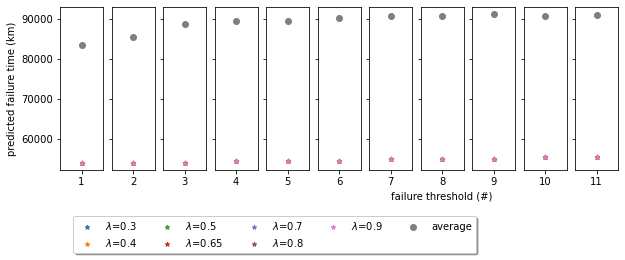

In [407]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(10, 3), sharey=True)

failure_counts = [1,2,3,4,5,6,7,8,9,10,11]
i = 0

for failure_count in failure_counts:  
    alarm_num_true = pd.Series(alarm_num_true)
    alarm_num_mean = pd.Series(alarm_num_mean)
    failure_index_true = alarm_num_true[alarm_num_true>failure_count].index[0]
    failure_time_true = df_wheel5.mileage[failure_index_true]
    failure_index_mean = alarm_num_mean[alarm_num_mean>failure_count].index[0]
    failure_time_mean = t_y_test_transfer[failure_index_mean]

    if i == 0:
        for lamb in lambdas:
            signal_lamb = results['predictions_forecast_transfer_inv'+str(lamb)]
            alarm_num = alarm(signal_lamb,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,np.abs(failure_time-failure_time_true),s=20,marker='*',label='$\lambda$='+str(lamb))
    
        axs[i].scatter(failure_count,np.abs(failure_time_mean-failure_time_true),label='average')
        axs[i].set_xticks([failure_count])
        
    else:
        for lamb in lambdas:
            signal_lamb = results['predictions_forecast_transfer_inv'+str(lamb)]
            alarm_num = alarm(signal_lamb,lamb)
            alarm_num = pd.Series(alarm_num)
            failure_index = alarm_num[alarm_num>failure_count].index[0]
            failure_time = t_y_test_transfer[failure_index][0]
            print('lamb:',lamb,'   failure_time:',failure_time)  
            axs[i].scatter(failure_count,np.abs(failure_time-failure_time_true),s=20,marker='*')
    
        axs[i].scatter(failure_count,np.abs(failure_time_mean-failure_time_true),label='average')
        axs[i].set_xticks([failure_count])
        
        
    i = i+1

axs[0].legend(loc='upper center', bbox_to_anchor=(5, -0.25),
          fancybox=True, shadow=True, ncol=5)

axs[7].set_xlabel('failure threshold (#)')
axs[0].set_ylabel('predicted failure time (km)')

fig.tight_layout()


# END